In [1]:
#installation des libraries à utilisées
if(!require(tidyverse)) install.packages("tidyverse",repos = "http://cran.us.r-project.org") 
if(!require(kableExtra)) install.packages("kableExtra",repos = "http://cran.us.r-project.org")
if(!require(tidyr)) install.packages("tidyr",repos = "http://cran.us.r-project.org")
if(!require(tidyverse)) install.packages("tidyverse",repos = "http://cran.us.r-project.org")
if(!require(stringr)) install.packages("stringr",repos = "http://cran.us.r-project.org")
if(!require(forcats)) install.packages("forcats",repos = "http://cran.us.r-project.org")
if(!require(ggplot2)) install.packages("ggplot2",repos = "http://cran.us.r-project.org")
if(!require(caret)) install.packages("caret", repos = "http://cran.us.r-project.org")
print("Fin d'installation")

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: kableExtra
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘kableExtra’”also installing the dependency ‘webshot’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: caret
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



[1] "Fin d'installation"


In [2]:
# chargement de toutes les libraries 

library(dplyr)
library(tidyverse)
library(kableExtra)
library(tidyr)
library(stringr)
library(forcats)
library(ggplot2)
library(caret)
print("toutes les libraries ont été chargé")


Attaching package: ‘kableExtra’

The following object is masked from ‘package:dplyr’:

    group_rows



[1] "toutes les libraries ont été chargé"


In [3]:
# Ecrivons  la fonction qui calcul le  RMSE

RMSE <- function(true_ratings = NULL, predicted_ratings = NULL) {
    sqrt(mean((true_ratings - predicted_ratings)^2))
}

In [4]:
dl <- tempfile()
download.file("http://files.grouplens.org/datasets/movielens/ml-10m.zip", dl)

ratings <- read.table(text = gsub("::", "\t", readLines(unzip(dl, "ml-10M100K/ratings.dat"))),
                      col.names = c("userId", "movieId", "rating", "timestamp"))

movies <- str_split_fixed(readLines(unzip(dl, "ml-10M100K/movies.dat")), "\\::", 3)
colnames(movies) <- c("movieId", "title", "genres")
movies <- as.data.frame(movies) %>% mutate(movieId = as.numeric(levels(movieId))[movieId],
                                           title = as.character(title),
                                           genres = as.character(genres))

movielens <- left_join(ratings, movies, by = "movieId")

In [5]:
# on garde 10% comme données d'echantillonnage ou encore données de validation 

set.seed(1)
test_index <- createDataPartition(y = movielens$rating, times = 1, p = 0.1, list = FALSE)
edx <- movielens[-test_index,]
temp <- movielens[test_index,]

In [6]:
# Make sure userId and movieId in validation set are also in edx set

validation <- temp %>% 
     semi_join(edx, by = "movieId") %>%
     semi_join(edx, by = "userId")

In [7]:
# Add rows removed from validation set back into edx set

removed <- anti_join(temp, validation)
edx <- rbind(edx, removed)

Joining, by = c("userId", "movieId", "rating", "timestamp", "title", "genres")


In [8]:
# Clean up memory by deleting unsused objects and performing a garbage collection 
rm(dl, ratings, movies, test_index, temp, movielens, removed)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11209469,598.7,18864692,1007.5,24598705,1313.8
Vcells,91254136,696.3,306803476,2340.8,282418626,2154.7


## Netoyage des données 

In [9]:
dim(edx)

[1] 9000055       6

In [10]:
head(edx)

,userId,movieId,rating,timestamp,title,genres
,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,1,122,5,838985046,Boomerang (1992),Comedy|Romance
2,1,185,5,838983525,"Net, The (1995)",Action|Crime|Thriller
4,1,292,5,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
5,1,316,5,838983392,Stargate (1994),Action|Adventure|Sci-Fi
6,1,329,5,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
7,1,355,5,838984474,"Flintstones, The (1994)",Children|Comedy|Fantasy


# Explorons les données

In [11]:
# --- EXPLORING MOVIES --------------------------------------

edx_movies <- edx %>%
    group_by(movieId) %>%
    summarize(count = n()) %>%
    arrange(desc(count))

summary(edx_movies$count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    30.0   122.0   842.9   565.0 31362.0 

### Distribution des votes 

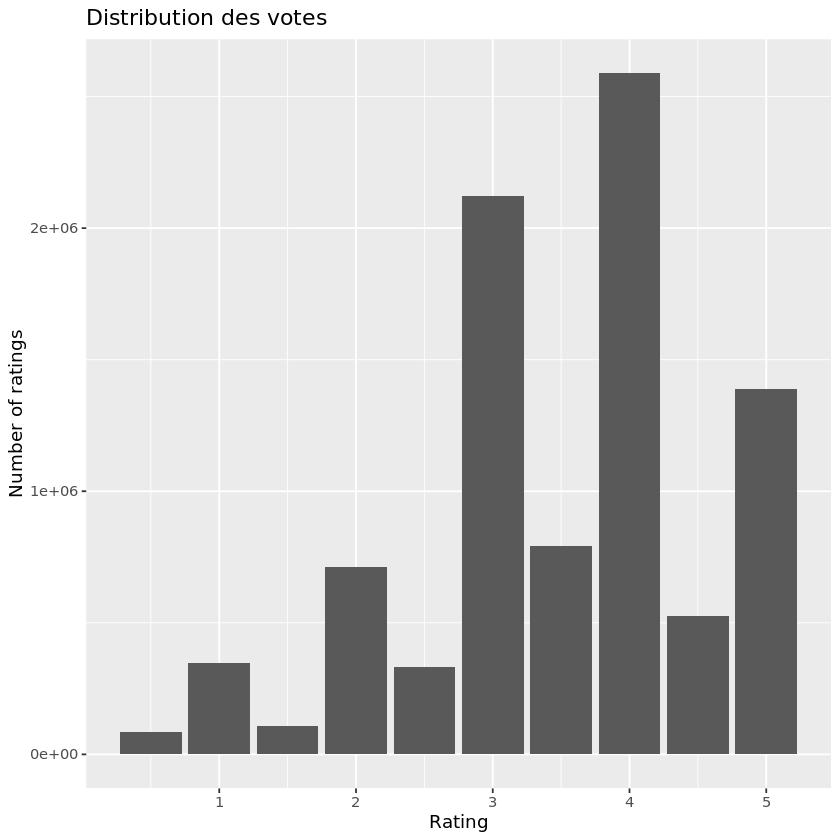

In [12]:
# Distribution of ratings
ggplot(data = edx, aes(x = rating)) +
    geom_bar() + 
    labs(title = "Distribution des votes", x = "Rating", y = "Number of ratings")

### Representons la notation des films par an

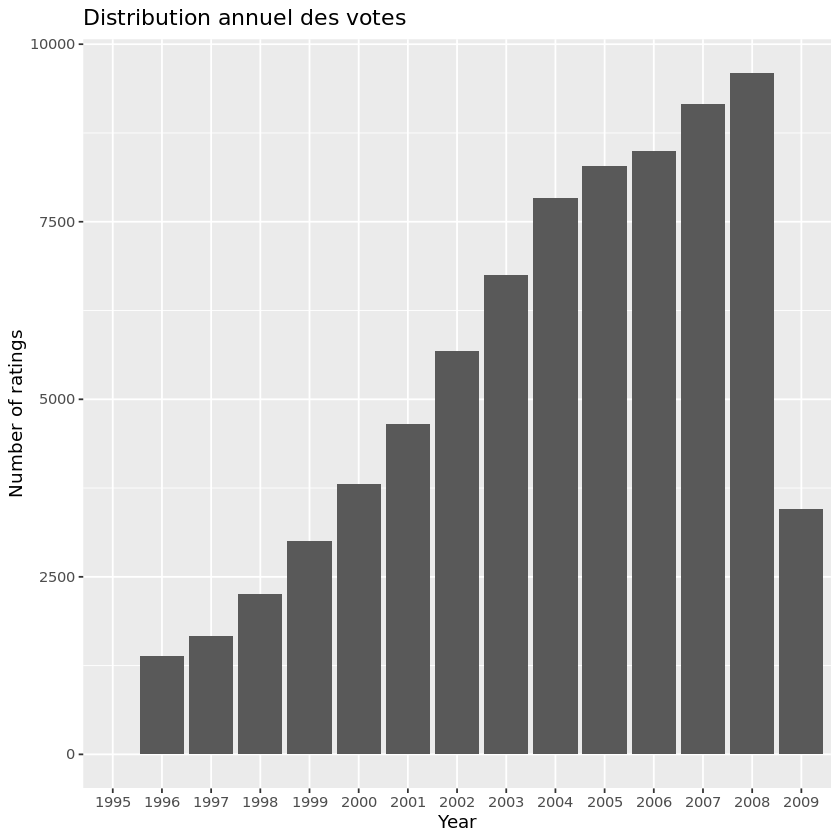

In [13]:
movies_year <- edx %>%
    transform(timestamp = format(as.POSIXlt(timestamp, origin = "1970-01-01"), "%Y")) %>%
    select(timestamp, movieId) %>%
    group_by(timestamp) %>%
    summarise(count = n_distinct(movieId))
              
ggplot(data = movies_year, aes(x = timestamp, y = count)) +
    geom_bar(stat = "identity") + 
    labs(title = "Distribution annuel des votes", x = "Year", y = "Number of ratings")

## Elaboration et Optimisation du modèle

#### Just the average method

Nous commençons avec un modèle qui assume la même note pour tous les films et tous les utilisateurs, avec toutes les différences expliquées par une variation aléatoire:

Si μ représente la vraie note pour tous les films et utilisateurs et ϵ représente les erreurs indépendantes échantillonnées à partir du même distribution centrée à zéro, alors:
Yu,i= μ + ϵμ,i

* Dans ce cas, l'estimation des moindres carrés de μ ** - l'estimation qui minimise l'erreur quadratique moyenne - est la note moyenne de tous les films pour tous les utilisateurs.

In [22]:
# calculate the overall average rating on the training dataset
μ <- mean(edx$rating)

# predict all unknown ratings with mu and calculate the RMSE
RMSE(validation$rating, μ)

[1] 1.061202

#### Movie effect method

Nous pouvons améliorer notre modèle en ajoutant un terme, *bi* qui représente la note moyenne du film i:


Yu, i = μ + bi + ϵμi

Dans ce cas bi est la moyenne de Y_ {u, i} moins la moyenne globale pour chaque film i.

In [25]:
# add average ranking term, b_i
b_i <- edx %>%
  group_by(movieId) %>%
  summarize(b_i = mean(rating - μ))

# predict all unknown ratings with mu and b_i
predicted_ratings <- validation %>% 
  left_join(b_i, by='movieId') %>%
  mutate(pred = μ + b_i) %>%
  pull(pred)

# calculate RMSE of movie ranking effect
RMSE(validation$rating, predicted_ratings)

[1] 0.9439087

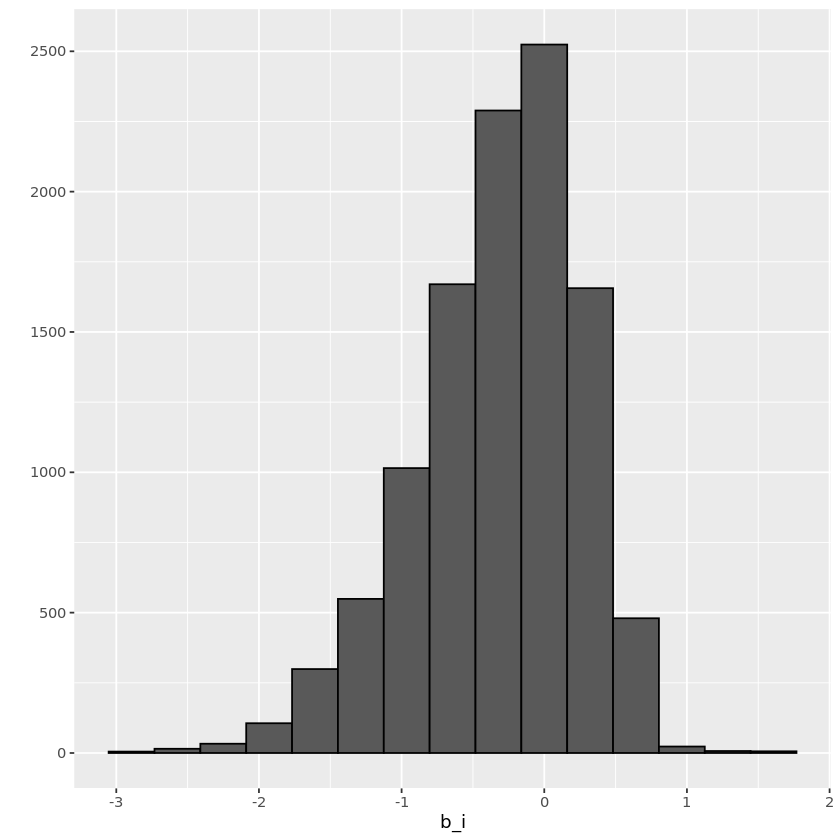

In [16]:
# plot the distribution of b_i's
qplot(b_i, data = b_i, bins = 15, color = I("black"))

#### Movie and user effect method

* Nous pouvons encore améliorer notre modèle en ajoutant bu, l'effet spécifique au user :
Yu, i = μ + bi + bu + ϵμ, i
* Notez que comme il y a des milliers de bs, la fonction lm sera très lente ou provoquera le crash de R, nous ne recommandons donc pas d'utiliser la régression linéaire pour calculer ces effets.

In [26]:
# compute user bias term, b_u
b_u <- edx %>% 
  left_join(b_i, by='movieId') %>%
  group_by(userId) %>%
  summarize(b_u = mean(rating - μ - b_i))

# predict new ratings with movie and user bias
predicted_ratings <- validation %>% 
  left_join(b_i, by='movieId') %>%
  left_join(b_u, by='userId') %>%
  mutate(pred = μ + b_i + b_u) %>%
  pull(pred)

# calculate RMSE of movie ranking effect
RMSE(predicted_ratings, validation$rating)

[1] 0.8653488

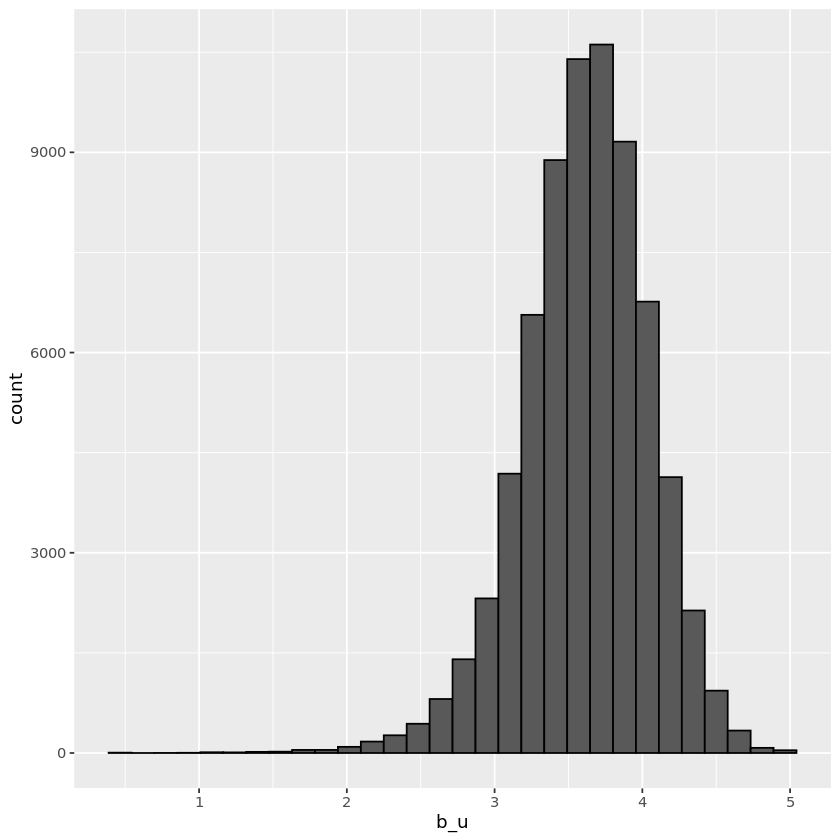

In [27]:
edx %>% 
     group_by(userId) %>% 
     summarize(b_u = mean(rating)) %>% 
     filter(n()>=100) %>%
     ggplot(aes(b_u)) + 
     geom_histogram(bins = 30, color = "black")

#### Regularized movie and user effect method

Au lieu de seulement chercher à minimiser la perte, nous allons minimiser à la fois la perte et la complexité, ce qui s'appelle la minimisation du risque structurel :

Notre algorithme d'optimisation de l'apprentissage est désormais une fonction à deux facteurs : **le facteur de perte**, qui mesure l'efficacité d'apprentissage du modèle, et **le facteur de régularisation**, qui mesure la complexité du modèle.

In [18]:
# determine best lambda from a sequence
lambdas <- seq(from=0, to=10, by=0.25)

# output RMSE of each lambda, repeat earlier steps (with regularization)
rmses <- sapply(lambdas, function(l){
  # calculate average rating across training data
  μ <- mean(edx$rating)
  # compute regularized movie bias term
  b_i <- edx %>% 
    group_by(movieId) %>%
    summarize(b_i = sum(rating - μ)/(n()+l))
  # compute regularize user bias term
  b_u <- edx %>% 
    left_join(b_i, by="movieId") %>%
    group_by(userId) %>%
    summarize(b_u = sum(rating - b_i - μ)/(n()+l))
  # compute predictions on validation set based on these above terms
  predicted_ratings <- validation %>% 
    left_join(b_i, by = "movieId") %>%
    left_join(b_u, by = "userId") %>%
    mutate(pred = μ + b_i + b_u) %>%
    pull(pred)
  # output RMSE of these predictions
  return(RMSE(predicted_ratings, validation$rating))
})


[1] 0.864817

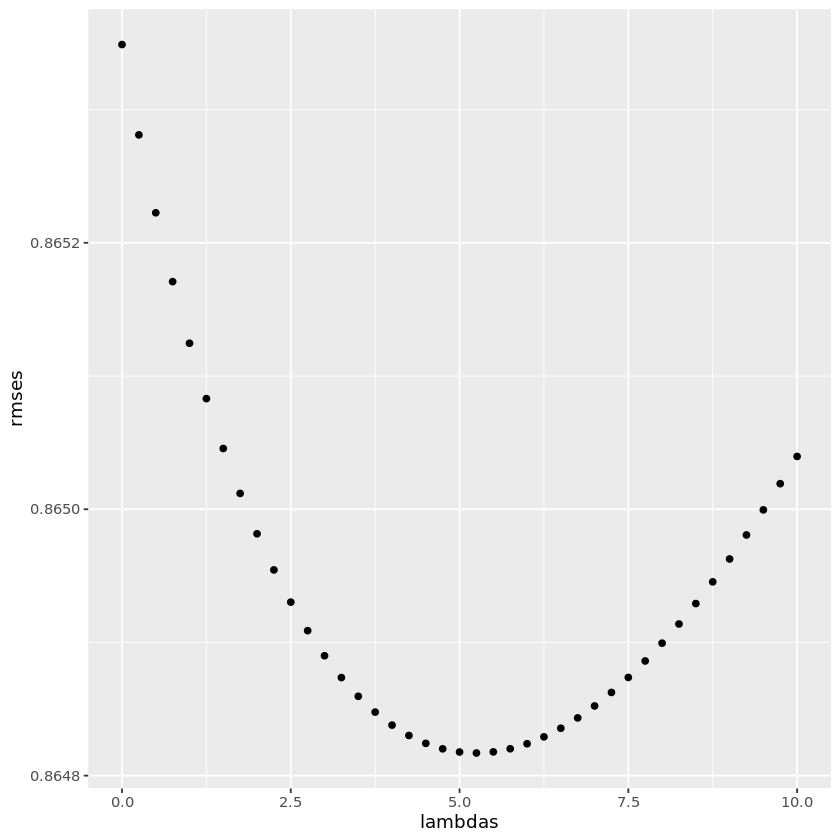

In [19]:
# quick plot of RMSE vs lambdas
qplot(lambdas, rmses)
# print minimum RMSE 
min(rmses)

#### Final model with regularized movie and user effects

In [20]:

# The final linear model with the minimizing lambda
lam <- lambdas[which.min(rmses)]

b_i <- edx %>% 
  group_by(movieId) %>%
  summarize(b_i = sum(rating - μ)/(n()+lam))
# compute regularize user bias term
b_u <- edx %>% 
  left_join(b_i, by="movieId") %>%
  group_by(userId) %>%
  summarize(b_u = sum(rating - b_i - μ)/(n()+lam))
# compute predictions on validation set based on these above terms
predicted_ratings <- validation %>% 
  left_join(b_i, by = "movieId") %>%
  left_join(b_u, by = "userId") %>%
  mutate(pred = μ + b_i + b_u) %>%
  pull(pred)
# output RMSE of these predictions
RMSE(predicted_ratings, validation$rating)

[1] 0.864817

Recapitulatif